In [2]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langgraph.graph import MessagesState,StateGraph, START
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display
from dotenv import load_dotenv
from config import SYSTEM_PROMPT, PARSER, APIKeysConfig
from custom_tools import *

In [3]:
load_dotenv()
llm = ChatOpenAI()

tools=[Weather, TopAttractions, Accommodation, CurrencyExchange]
llm_with_tools=llm.bind_tools(tools)

In [4]:
def routing(state: MessagesState):
    query = state["messages"]

    last_message = query[-1]
    last_message.content += f"\n\n{PARSER.get_format_instructions()}"

    input_question = [SYSTEM_PROMPT] + query
    response = llm_with_tools.invoke(input_question)

    try:
        parsed_query = PARSER.parse(response.content)
    except Exception as e:
        parsed_query = f"Parsing failed: {str(e)}"

    return {
        "messages": [response],
        "parsed_query": parsed_query
    }

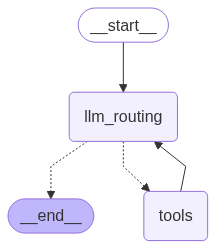

In [5]:
workflow = StateGraph(MessagesState)

workflow.add_node("llm_routing", routing)
workflow.add_node("tools", ToolNode(tools))

workflow.add_edge(START, "llm_routing")

workflow.add_conditional_edges(
    "llm_routing",
    tools_condition,
)
workflow.add_edge("tools", "llm_routing")

app = workflow.compile()
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [6]:
messages = [HumanMessage(content="Plan a nice trip to Milan for 10 days and share the budget in USD")]
response = app.invoke({"messages": messages})

for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Plan a nice trip to Milan for 10 days and share the budget in USD

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"city": {"description": "List of city names", "items": {"type": "string"}, "title": "City", "type": "array"}, "duration": {"anyOf": [{"type": "integer"}, {"type": "null"}], "default": null, "description": "Trip duration in days", "title": "Duration"}, "start_date": {"anyOf": [{"format": "date", "type": "string"}, {"type": "null"}], "default": null, "description": "Start date of the

In [8]:
for msg in response['messages']:
    if msg.__class__.__name__ in ['HumanMessage', 'AIMessage']:
        if msg.content.strip():
            print(msg.content)

Plan a nice trip to Milan for 10 days and share the budget in PKR

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"city": {"description": "List of city names", "items": {"type": "string"}, "title": "City", "type": "array"}, "duration": {"anyOf": [{"type": "integer"}, {"type": "null"}], "default": null, "description": "Trip duration in days", "title": "Duration"}, "start_date": {"anyOf": [{"format": "date", "type": "string"}, {"type": "null"}], "default": null, "description": "Start date of the trip", "title": "Start Date"}, "end_date": {"anyOf": [{"format": "date", "type": 